<a href="https://colab.research.google.com/github/GaetanAm/Sentiment-Analysis-and-Impact-on-Financial-Markets/blob/main/notebooks/Stage_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports nécessaires
import pandas as pd
import yfinance as yf
import plotly.express as px
import zipfile
import json
import os
from google.colab import files
from datetime import date
from lxml import etree
from io import StringIO
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from huggingface_hub import login
from transformers import pipeline
from google.colab import userdata
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import plot_tree

# Désactiver les avertissements inutiles
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
tickers = ['TSLA', 'AAPL', 'AMZN', 'JPM', 'NFLX', 'NVDA', 'GOOG', 'NKE', 'DIS', 'BABA', 'SHOP']
start = '2010-01-01'
end = '2018-12-31'
df_ticker_return = pd.DataFrame()
for ticker in tickers:
    ticker_yf = yf.Ticker(ticker)
    if df_ticker_return.empty:
        df_ticker_return = ticker_yf.history(start = start, end = end)
        df_ticker_return['ticker']= ticker
    else:
        data_temp = ticker_yf.history(start = start, end = end)
        data_temp['ticker']= ticker
        # Use pandas.concat instead of append
        df_ticker_return = pd.concat([df_ticker_return, data_temp])
df_ticker_return.to_csv(r'return_data.csv')

In [ ]:
df_ticker_return.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker
Date,,,,,,,,
2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0,TSLA
2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0,TSLA
2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0,TSLA
2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0,TSLA
2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0,TSLA


In [ ]:
# We can preread the data
df_ticker_return = pd.read_csv('return_data.csv',
                               index_col='Date')
df_ticker_return.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker
Date,,,,,,,,
2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0,TSLA
2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0,TSLA
2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0,TSLA
2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0,TSLA
2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0,TSLA


In [ ]:
tickers = list(df_ticker_return['ticker'].unique())
print(tickers)

['TSLA', 'AAPL', 'AMZN', 'JPM', 'NFLX', 'NVDA', 'GOOG', 'NKE', 'DIS', 'BABA', 'SHOP']


In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Charger les données
df = pd.read_csv('return_data.csv', index_col='Date', parse_dates=True)

# Vérifier les valeurs manquantes
print("Valeurs manquantes par colonne :\n", df.isnull().sum())

# Imputation des valeurs manquantes par la moyenne
imputer = SimpleImputer(strategy='mean')
df.iloc[:, :-1] = imputer.fit_transform(df.iloc[:, :-1])  # Ignorer la colonne 'ticker'


Valeurs manquantes par colonne :
 Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
ticker          0
dtype: int64


In [ ]:
# Standardisation avec StandardScaler
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled.iloc[:, :-1] = scaler.fit_transform(df.iloc[:, :-1])

# Normalisation avec MinMaxScaler
minmax_scaler = MinMaxScaler()
df_normalized = df.copy()
df_normalized.iloc[:, :-1] = minmax_scaler.fit_transform(df.iloc[:, :-1])


In [ ]:
# Ajouter une colonne fictive 'target' pour la démonstration
df['target'] = (df['Close'] > df['Close'].median()).astype(int)

# Utiliser SMOTE pour équilibrer les classes
smote = SMOTE()
X = df.drop(columns=['target', 'ticker'])
y = df['target']
X_resampled, y_resampled = smote.fit_resample(X, y)

# Vérifier les nouvelles proportions
print("Proportions après SMOTE :\n", y_resampled.value_counts())


Proportions après SMOTE :
 target
0    11116
1    11116
Name: count, dtype: int64


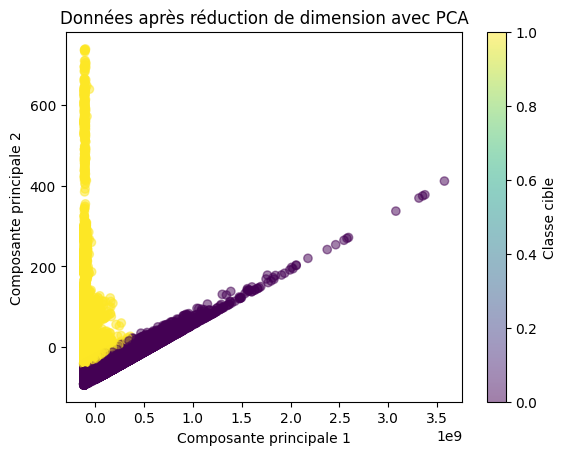

In [ ]:
# Appliquer PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_resampled)

# Visualiser les données réduites
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_resampled, cmap='viridis', alpha=0.5)
plt.title("Données après réduction de dimension avec PCA")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.colorbar(label='Classe cible')
plt.show()


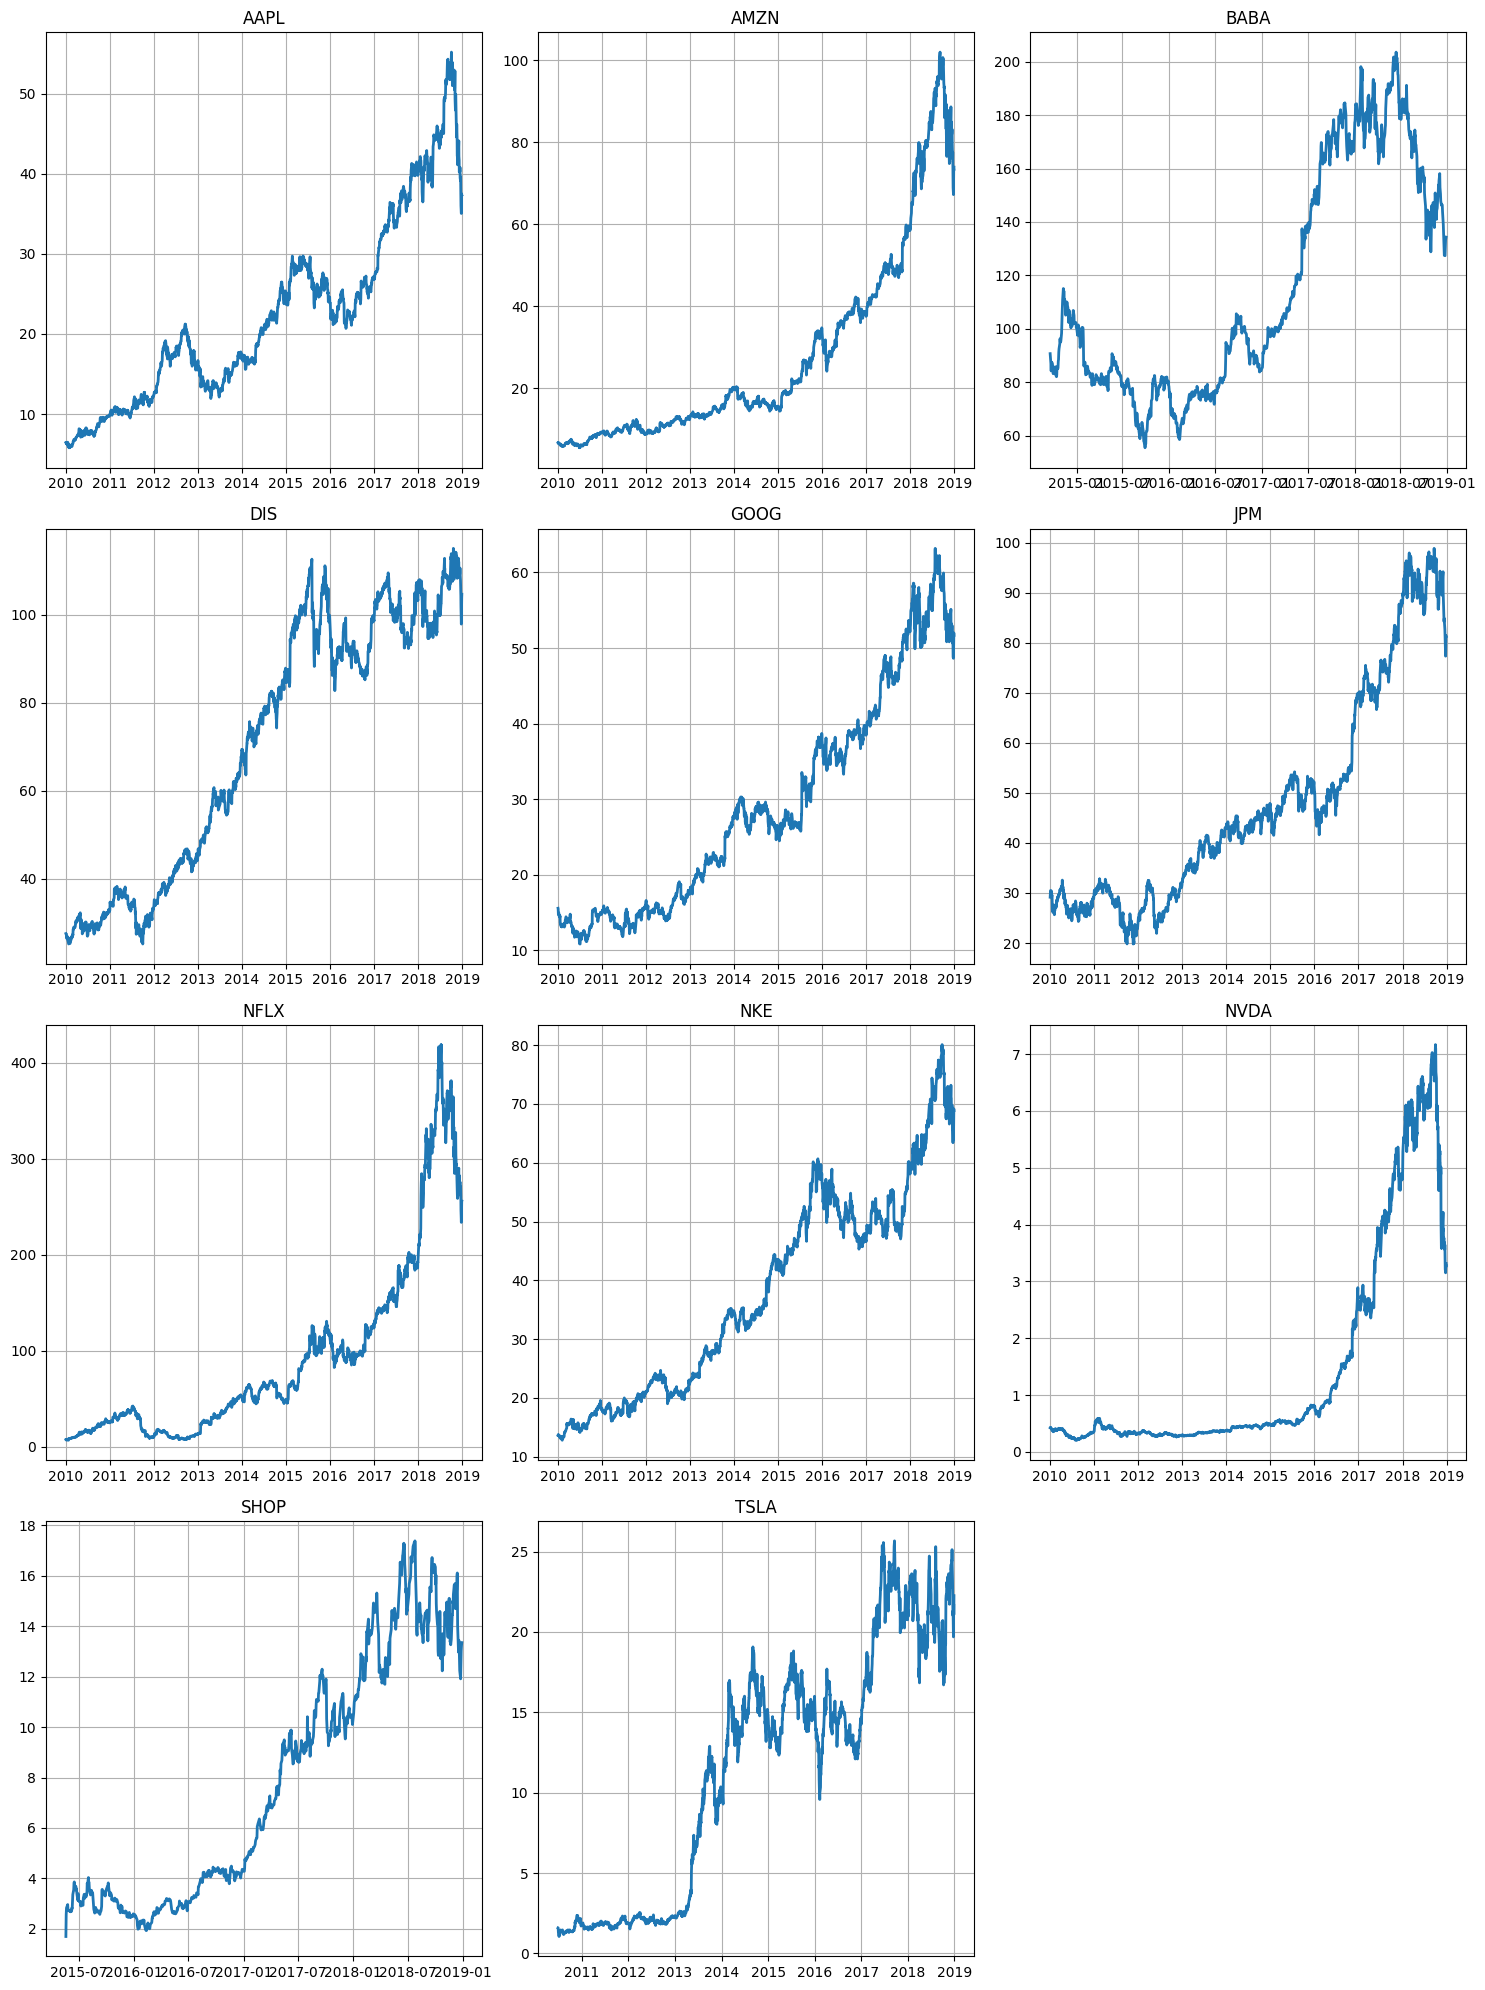

In [ ]:
import math

# Calculer le nombre de tickers
tickers = list(df['ticker'].unique())
num_tickers = len(tickers)

# Déterminer les dimensions de la grille
cols = 3  # Fixer le nombre de colonnes
rows = math.ceil(num_tickers / cols)  # Calculer dynamiquement le nombre de lignes

# Créer la grille avec le bon nombre de sous-graphiques
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 5 * rows))
axes = axes.flatten()

# Tracer les séries par ticker
for idx, (ticker, group) in enumerate(df.groupby('ticker')):
    axes[idx].plot(group['Close'], linewidth=2, label=ticker)
    axes[idx].set_title(ticker)
    axes[idx].grid(True)

# Désactiver les axes inutilisés (si les sous-graphiques dépassent le nombre de tickers)
for ax in axes[num_tickers:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Raw Headline Data.zip to Raw Headline Data.zip


In [ ]:
import zipfile
import json
import os

# Get the current working directory
current_directory = os.getcwd()

# Construct the path to the zip file relative to the current directory
zip_file_path = os.path.join(current_directory, "Raw Headline Data.zip")

# Print the path to verify it's correct
print(f"Looking for the file at: {zip_file_path}")

# Try opening the zip file
try:
    z = zipfile.ZipFile(zip_file_path, "r")
    testFile = z.namelist()[10]
    fileData = z.open(testFile).read()
    fileDataSample = json.loads(fileData)['content'][1:500]

    # json format
    print(fileDataSample)

except FileNotFoundError:
    print(f"Error: File not found at {zip_file_path}. Please ensure the file is present and the path is correct.")

Looking for the file at: /content/Raw Headline Data.zip
li class="n-box-item date-title" data-end="1305172799" data-start="1305086400" data-txt="Tuesday, December 17, 2019">Wednesday, May 11, 2011</li><li class="n-box-item sa-box-item" data-id="76179" data-ts="1305149244"><div class="media media-overflow-fix"><div class="media-left"><a class="box-ticker" href="/symbol/CSCO" target="_blank">CSCO</a></div><div class="media-body"><h4 class="media-heading"><a href="/news/76179" sasource="on_the_move_news_fidelity" target="_blank">Cisco (NASDAQ:CSCO): Pr


In [ ]:
from lxml import etree
from io import StringIO
from datetime import date
from tqdm.notebook import tqdm

# helper function performs the jsn parsing

def jsonParser(json_data):
    xml_data = json_data['content']

    tree = etree.parse(StringIO(xml_data), parser=etree.HTMLParser())

    headlines = tree.xpath("//h4[contains(@class, 'media-heading')]/a/text()")
    assert len(headlines) == json_data['count']

    main_tickers = list(map(lambda x: x.replace('/symbol/', ''), tree.xpath("//div[contains(@class, 'media-left')]//a/@href")))
    assert len(main_tickers) == json_data['count']
    final_headlines = [''.join(f.xpath('.//text()')) for f in tree.xpath("//div[contains(@class, 'media-body')]/ul/li[1]")]
    if len(final_headlines) == 0:
        final_headlines = [''.join(f.xpath('.//text()')) for f in tree.xpath("//div[contains(@class, 'media-body')]")]
        final_headlines = [f.replace(h, '').split('\xa0')[0].strip() for f,h in zip (final_headlines, headlines)]

    return main_tickers, final_headlines


data = None
data_df_news = []
ret = []
ret_f = []
with zipfile.ZipFile("/content/Raw Headline Data.zip", "r") as z:

    for filename in tqdm(z.namelist()):
#         print(filename)
        try:
            #print('Running {}'.format(filename))
            with z.open(filename) as f:
                data = f.read()
                json_data = json.loads(data)
            if json_data.get('count', 0)> 10:

                #Step 1: Parse the News Jsons
                main_tickers, final_headlines = jsonParser(json_data)

                if len(final_headlines) != json_data['count']:
                    continue

                #Step 2: Prepare Future and Event Return and assign Future and Event return for each ticker.
                file_date = filename.split('/')[-1].replace('.json', '')
                file_date = date(int(file_date[:4]), int(file_date[5:7]), int(file_date[8:]))

               #Step 3: Merge all the data in a data frame
                df_dict = {'ticker': main_tickers,
                           'headline': final_headlines,
                           'date': [file_date] * len(main_tickers)}

                df_f = pd.DataFrame(df_dict)
                data_df_news.append(df_f)

        except:
            pass

data_df_news=pd.concat(data_df_news)
display(data_df_news.head())
print(data_df_news.shape)

  0%|          | 0/3159 [00:00<?, ?it/s]

,ticker,headline,date
0,DVA,Davita (NYSE:DVA): EPS of $0.96 beats by $0.01...,2011-05-02
1,CGNX,Cognex (NASDAQ:CGNX): EPS of $0.32 beats by $0...,2011-05-02
2,AEIS,Advanced Energy Industries (NASDAQ:AEIS):,2011-05-02
3,LOCM,Local.com (NASDAQ:LOCM):,2011-05-02
4,CYDEQ,CyberDefender (CYDE):,2011-05-02


(122613, 3)


In [ ]:
# select all tickers except for empty
data_df_news = data_df_news[~(data_df_news['ticker'] == '')]
data_df_news.shape

(110711, 3)

In [ ]:
px.bar(data_df_news['ticker'].value_counts()[:100],template="plotly_white")

In [ ]:
#Computing the return
df_ticker_return['ret_curr'] = df_ticker_return['Close'].pct_change()

#Computing the event return
rtp1 = df_ticker_return['ret_curr'].shift(1) # return a day after the news
rt = df_ticker_return['ret_curr'] # return the day of the news

df_ticker_return['eventRet'] =  rt + rtp1
df_ticker_return.reset_index(level=0, inplace=True)

df_ticker_return['date'] = pd.to_datetime(df_ticker_return['Date']).apply(lambda x: x.date())

In [ ]:
# merge on date and ticker
df_all = pd.merge(data_df_news, df_ticker_return,
                  how='left',
                  left_on=['date','ticker'],
                  right_on=['date','ticker'])

df_all = df_all[df_all['ticker'].isin(tickers)]
df_all = df_all[['ticker','headline','date','eventRet','Close']]
df_all = df_all.dropna()
df_all = df_all.reset_index(drop=True)
df_all.to_csv('combined.csv',index=False)

In [ ]:
# preread combined dataframe
data_df = pd.read_csv('combined.csv')
data_df = data_df.dropna()
data_df.head()

,ticker,headline,date,eventRet,Close
0,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.031269,10.059500
1,NFLX,Netflix (NFLX +1.1%) shares post early gains a...,2011-05-02,0.012173,33.884285
2,AMZN,Amazon.com (AMZN -1.7%) shares slip as comment...,2011-05-12,0.010426,10.303500
3,NVDA,Nvidia (NVDA -8.2%) shares slump after Needham...,2011-05-13,-0.077562,0.418649
4,GOOG,"It's been some time coming, but Google (GOOG -...",2011-05-16,-0.031297,12.865873


In [ ]:
print(data_df.shape, data_df.ticker.unique().shape)

(2586, 5) (11,)


In [ ]:
data_df['sent_blob'] = data_df['headline'].apply(lambda row: TextBlob(row).sentiment.polarity)
data_df.head()

,ticker,headline,date,eventRet,Close,sent_blob
0,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.031269,10.059500,0.262500
1,NFLX,Netflix (NFLX +1.1%) shares post early gains a...,2011-05-02,0.012173,33.884285,-0.043750
2,AMZN,Amazon.com (AMZN -1.7%) shares slip as comment...,2011-05-12,0.010426,10.303500,0.000000
3,NVDA,Nvidia (NVDA -8.2%) shares slump after Needham...,2011-05-13,-0.077562,0.418649,0.113636
4,GOOG,"It's been some time coming, but Google (GOOG -...",2011-05-16,-0.031297,12.865873,0.125000


In [ ]:
login(userdata.get('LOGIN_HF'))
# Charger FinBERT
sentiment_pipeline = pipeline("sentiment-analysis", model="yiyanghkust/finbert-tone")
def analyze_sentiment(text):
    try:
        return sentiment_pipeline(inputs=text)[0]['label']  # Utiliser "inputs" si "text" ne fonctionne pas
    except Exception as e:
        print(f"Erreur avec le texte : {text} -> {e}")
        return "Error"
# Appliquer l'analyse des sentiments à tous les titres
data_df['sent_finbert'] = data_df['headline'].apply(analyze_sentiment)

# Afficher un aperçu des résultats
print(data_df[['headline', 'sent_finbert']].head())

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

Device set to use cpu


KeyboardInterrupt: 

In [ ]:
data_df.head()

In [ ]:
def map_finbert_sentiment(label):
    if label == "Positive":
        return 1
    elif label == "Negative":
        return -1
    else:
        return 0

data_df['sent_finbert_score'] = data_df['sent_finbert'].apply(map_finbert_sentiment)

In [ ]:
data_df.head()

In [ ]:
# Suppression de la colonne 'sent_finbert'
data_df = data_df.drop(columns=['sent_finbert'])

# Sauvegarder le DataFrame en CSV
csv_path = "sentiment_data.csv"
data_df.to_csv(csv_path, index=False)

# Télécharger le fichier CSV

# files.download(csv_path)

# ANALYSE SENT BLOB V SENT FIN

In [ ]:
uploaded = files.upload()

Saving sentiment_data.csv to sentiment_data.csv


In [ ]:
data_df = pd.read_csv("sentiment_data.csv")

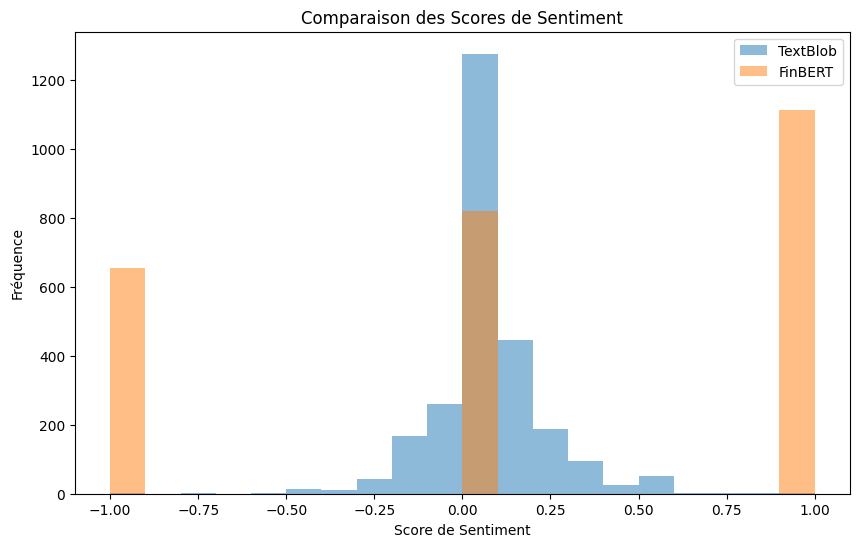

In [ ]:
# Comparer les distributions
plt.figure(figsize=(10, 6))
plt.hist(data_df['sent_blob'], bins=20, alpha=0.5, label='TextBlob')
plt.hist(data_df['sent_finbert_score'], bins=20, alpha=0.5, label='FinBERT')
plt.legend()
plt.title("Comparaison des Scores de Sentiment")
plt.xlabel("Score de Sentiment")
plt.ylabel("Fréquence")
plt.show()

In [ ]:
# Calcul des corrélations
print(data_df[['eventRet', 'sent_blob', 'sent_finbert_score']].corr())

                    eventRet  sent_blob  sent_finbert_score
eventRet            1.000000   0.075331            0.294376
sent_blob           0.075331   1.000000            0.203759
sent_finbert_score  0.294376   0.203759            1.000000


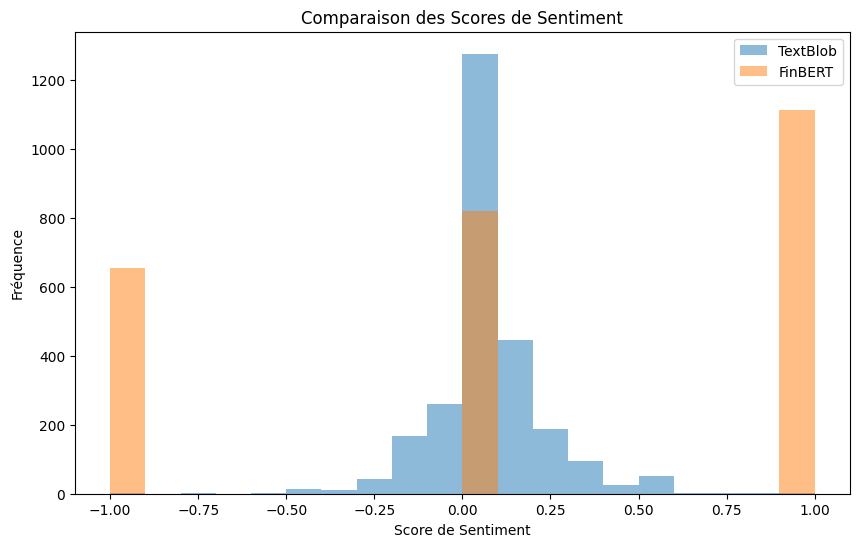

In [ ]:
# Comparer les distributions
plt.figure(figsize=(10, 6))
plt.hist(data_df['sent_blob'], bins=20, alpha=0.5, label='TextBlob')
plt.hist(data_df['sent_finbert_score'], bins=20, alpha=0.5, label='FinBERT')
plt.legend()
plt.title("Comparaison des Scores de Sentiment")
plt.xlabel("Score de Sentiment")
plt.ylabel("Fréquence")
plt.show()

In [ ]:
# Calcul des corrélations
print(data_df[['eventRet', 'sent_blob', 'sent_finbert_score']].corr())

                    eventRet  sent_blob  sent_finbert_score
eventRet            1.000000   0.075331            0.294376
sent_blob           0.075331   1.000000            0.203759
sent_finbert_score  0.294376   0.203759            1.000000


# MACHINE LEARNING

## SUR DONNEE COMBINEE

### REGRESSION LINEAIRE

In [ ]:
# Variables explicatives (sentiments) et cible (retour)
X = data_df[['sent_blob', 'sent_finbert_score']]
y = data_df['eventRet']  # Vous pouvez remplacer par 'Close'

# Diviser en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Modèle de régression linéaire
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Prédictions sur le test set
y_pred = lin_reg.predict(X_test)

# Évaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}")
print(f"R²: {r2}")

MSE: 0.004241378720764001
R²: 0.041962688376084745


In [ ]:
print(f"Coefficients: {lin_reg.coef_}")
print(f"Intercept: {lin_reg.intercept_}")

Coefficients: [0.00275955 0.02256794]
Intercept: -0.0010526457970336275


### REGRESSION LOGISTIQUE

In [ ]:
# Créer une variable binaire (par exemple, retour positif/négatif)
data_df['target_binary'] = (data_df['eventRet'] > 0).astype(int)

# Variables explicatives et cible
X = data_df[['sent_blob', 'sent_finbert_score']]
y = data_df['target_binary']

# Diviser en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Modèle de régression logistique
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [ ]:
# Prédictions
y_pred = log_reg.predict(X_test)

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matrice de confusion:")
print(conf_matrix)

# Rapport de classification
print("Rapport de classification:")
print(classification_report(y_test, y_pred))

# Précision globale
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Matrice de confusion:
[[105 144]
 [ 40 229]]
Rapport de classification:
              precision    recall  f1-score   support

           0       0.72      0.42      0.53       249
           1       0.61      0.85      0.71       269

    accuracy                           0.64       518
   macro avg       0.67      0.64      0.62       518
weighted avg       0.67      0.64      0.63       518

Accuracy: 0.6447876447876448


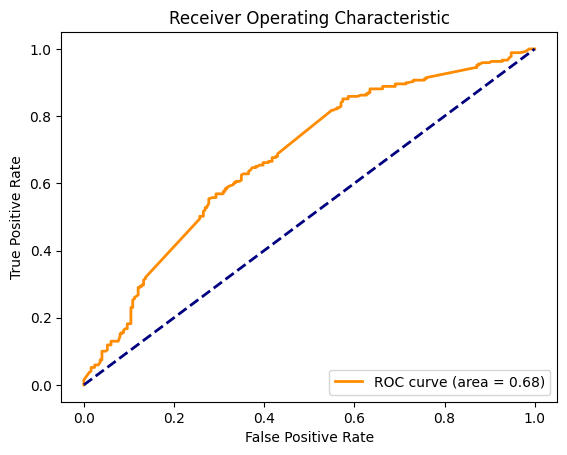

In [ ]:
# Scores de probabilité
y_proba = log_reg.predict_proba(X_test)[:, 1]

# Calcul des courbes ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Arbres de Décision

In [ ]:
# Modèle d'arbre de décision avec réglage de max_depth
tree_model = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=42)
tree_model.fit(X_train, y_train)

# Prédictions
y_pred_tree = tree_model.predict(X_test)

In [ ]:
# Matrice de confusion et rapport de classification
print("Rapport de classification (Arbre de décision):")
print(classification_report(y_test, y_pred_tree))

# Précision globale
accuracy_tree = accuracy_score(y_test, y_pred_tree)
print(f"Accuracy (Arbre de décision): {accuracy_tree}")

Rapport de classification (Arbre de décision):
              precision    recall  f1-score   support

           0       0.72      0.42      0.53       249
           1       0.61      0.85      0.71       269

    accuracy                           0.64       518
   macro avg       0.67      0.64      0.62       518
weighted avg       0.67      0.64      0.63       518

Accuracy (Arbre de décision): 0.6447876447876448


In [ ]:
plt.figure(figsize=(15, 10))
plot_tree(tree_model, feature_names=X.columns, class_names=['Class 0', 'Class 1'], filled=True)
plt.title("Arbre de Décision")
plt.show()

NameError: name 'plot_tree' is not defined

<Figure size 1500x1000 with 0 Axes>

In [ ]:
# Importance des caractéristiques
importances = tree_model.feature_importances_
for feature, importance in zip(X.columns, importances):
    print(f"Feature: {feature}, Importance: {importance:.4f}")

### Random Forest

In [ ]:
# Modèle Random Forest avec réglages
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

# Prédictions
y_pred_rf = rf_model.predict(X_test)

In [ ]:
# Matrice de confusion et rapport de classification
print("Rapport de classification (Random Forest):")
print(classification_report(y_test, y_pred_rf))

# Précision globale
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy (Random Forest): {accuracy_rf}")

In [ ]:
# Importance des caractéristiques
importances_rf = rf_model.feature_importances_
for feature, importance in zip(X.columns, importances_rf):
    print(f"Feature: {feature}, Importance: {importance:.4f}")

In [ ]:
# Validation croisée
cv_scores_rf = cross_val_score(rf_model, X, y, cv=5)
print(f"Validation croisée - Mean accuracy (Random Forest): {cv_scores_rf.mean():.4f}")

### k-Nearest Neighbors (KNN)

In [ ]:
# Modèle KNN avec réglage de k (nombre de voisins)
knn_model = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)  # Distance euclidienne (p=2)
knn_model.fit(X_train, y_train)

# Prédictions
y_pred_knn = knn_model.predict(X_test)

In [ ]:
# Matrice de confusion et rapport de classification
print("Rapport de classification (KNN):")
print(classification_report(y_test, y_pred_knn))

# Précision globale
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy (KNN): {accuracy_knn}")

In [ ]:
# Essayer différents k et mesurer la précision
k_values = range(1, 21)
accuracies = []

for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

# Tracer les précisions
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o')
plt.title("Précision en fonction de k (KNN)")
plt.xlabel("Nombre de voisins (k)")
plt.ylabel("Précision")
plt.grid()
plt.show()